# Feature Extraction

In [ ]:
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import torchvision.models
from torchvision import transforms, datasets, models
import torchvision
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
#setup Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

master_path = '/content/gdrive/My Drive/Colab Notebooks/APS360Project/'

Mounted at /content/gdrive


In [ ]:
model = torchvision.models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
def get_base_model():
    model = torchvision.models.resnet50(pretrained=True)
    modules = list(model.children())[:-1]
    model = nn.Sequential(*modules)
    return model

In [ ]:
model = get_base_model()
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
from collections import OrderedDict
NUM_OF_CLASSES = 101

def get_primary_model():
  model = torchvision.models.resnet50(pretrained=True)
  
  n_inputs = model.fc.in_features
  classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(n_inputs, 512)),
    ('dropout', nn.Dropout(0.4)),
    ('fc2', nn.Linear(512, NUM_OF_CLASSES))
  ]))

  model.fc = classifier

  return model

In [ ]:
model = get_primary_model()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def get_preprocess_pipeline():
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    preprocess = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]
    )
    return preprocess

In [ ]:
def extract_features(img_path, output_path):
    
    model = get_base_model()
    preprocess = get_preprocess_pipeline()
    
    print("[INFO] Instantiating Dataset Loader")
    
    data_set = torchvision.datasets.ImageFolder(
        root=image_path, transform=preprocess)
    data_loader = torch.utils.data.DataLoader(
        data_set, batch_size=1, shuffle=False)

    print("[INFO] Starting Feature Extraction")
    
    feature_list = list()
    filename_list = list()
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input_file = data_loader.dataset.samples[idx]
            features = model(data[0])
            feature_list.append(features.numpy()[0])
            filename_list.append(input_file[0])

            if idx % 1000 == 0:
                print("[INFO] Processing image {0} of {1}".format(idx, len(data_set)))

    print("[INFO] Saving Outputs")
    feature_list = feature_list[:,:,0,0]
    os.makedirs(output_path, exist_ok=True)
    np.save(os.path.join(output_path, "filenames.npy"), filename_list)
    np.save(os.path.join(output_path, "features.npy"), feature_list)

In [ ]:
image_path = master_path + 'caltech101/101_ObjectCategories'
output_path = master_path
extract_features(image_path, output_path)

In [ ]:
def extract_features_primary(img_path, output_path):
    
    model = get_primary_model()
    preprocess = get_preprocess_pipeline()
    
    print("[INFO] Instantiating Dataset Loader")
    
    data_set = torchvision.datasets.ImageFolder(
        root=image_path, transform=preprocess)
    data_loader = torch.utils.data.DataLoader(
        data_set, batch_size=1, shuffle=False)

    print("[INFO] Starting Feature Extraction")
    
    feature_list = list()
    filename_list = list()
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input_file = data_loader.dataset.samples[idx]
            features = model(data[0])
            feature_list.append(features.numpy()[0])
            filename_list.append(input_file[0])

            if idx % 1000 == 0:
                print("[INFO] Processing image {0} of {1}".format(idx, len(data_set))) 

    print("[INFO] Saving Outputs")
    os.makedirs(output_path, exist_ok=True)

    feature_list = feature_list[:,:,0,0]
    
    np.save(os.path.join(output_path, "filenames_primary.npy"), filename_list)
    np.save(os.path.join(output_path, "features_primary.npy"), feature_list)
    np.save(os.path)

In [ ]:
image_path = master_path + 'caltech101/101_ObjectCategories'
output_path = master_path
extract_features_primary(image_path, output_path)

[INFO] Instantiating Dataset Loader
[INFO] Starting Feature Extraction
[INFO] Processing image 0 of 8677
[INFO] Processing image 1000 of 8677
[INFO] Processing image 2000 of 8677
[INFO] Processing image 3000 of 8677
[INFO] Processing image 4000 of 8677
[INFO] Processing image 5000 of 8677
[INFO] Processing image 6000 of 8677
[INFO] Processing image 7000 of 8677
[INFO] Processing image 8000 of 8677
[INFO] Saving Outputs


# Similarity Search

In [ ]:
feature_list = np.load(master_path + 'features.npy')
filenames = np.load(master_path + 'filenames.npy')
primary_feature_list = np.load(master_path + 'features_primary.npy')

In [ ]:
feature_list.shape, primary_feature_list.shape

((8677, 2048, 1, 1), (8677, 101))

In [ ]:
feature_list = feature_list[:,:,0,0]
feature_list.shape

(8677, 2048)

In [ ]:
def get_fit_NN(features):
    model = NearestNeighbors(n_neighbors = 6, algorithm="brute", metric="euclidean")
    model.fit(features)
    return model


def similarity_search(input_img_path):
    preprocess = get_preprocess_pipeline()
    model = get_base_model()

    feature_list = np.load(master_path + 'features.npy')
    feature_list = feature_list[:,:,0,0]

    filename_list = np.load(master_path + 'filenames.npy')

    neighbors = get_fit_NN(feature_list)
    
    im = Image.open(input_img_path)
    im = preprocess(im)
    im = im.unsqueeze(0)
    with torch.no_grad():
        input_features = model(im).numpy()
        input_features = input_features[:,:,0,0]

    print("[INFO] Finding Similar Images")
    distances, indices = neighbors.kneighbors([input_features[0]], 5)
    similar_image_paths = filename_list[indices[0]]
    plot_images(similar_image_paths, distances[0])

In [ ]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

In [ ]:
# Helper functions to plot the nearest images given a query image
def plot_images_annoy(filenames):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]))
        plt.imshow(image)

In [ ]:
neighbors = get_fit_NN(feature_list)

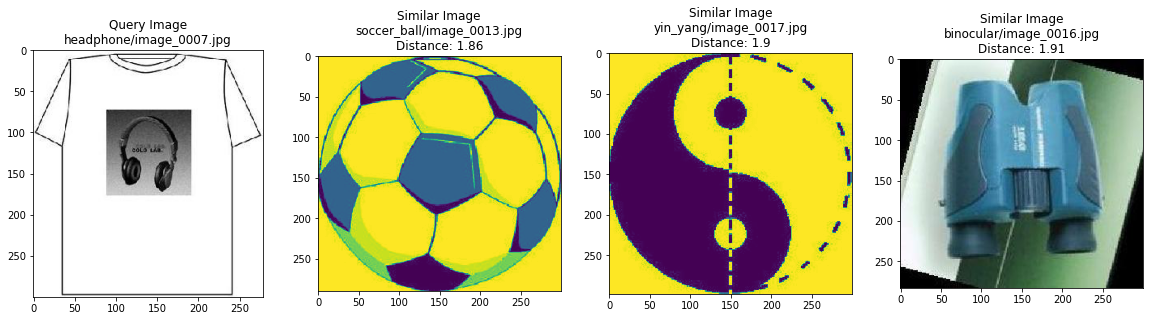

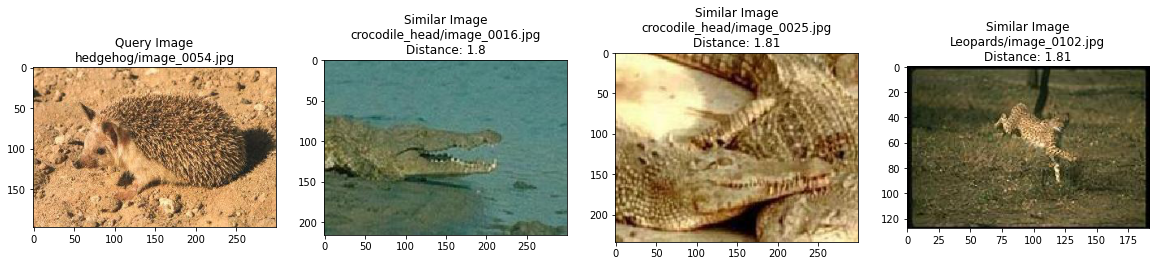

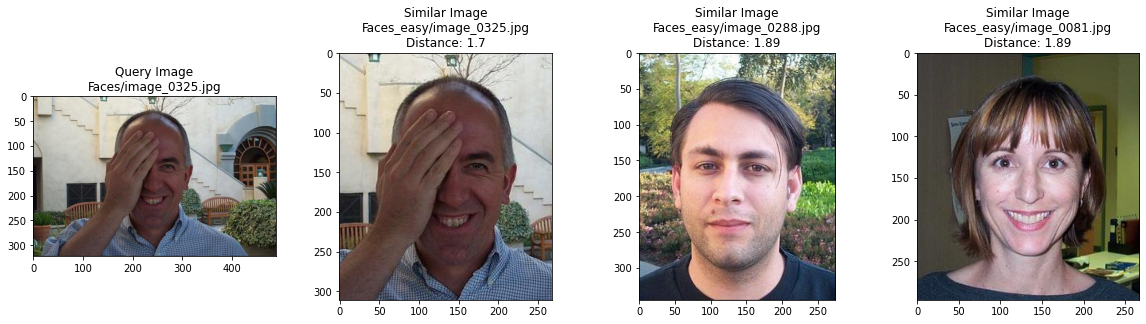

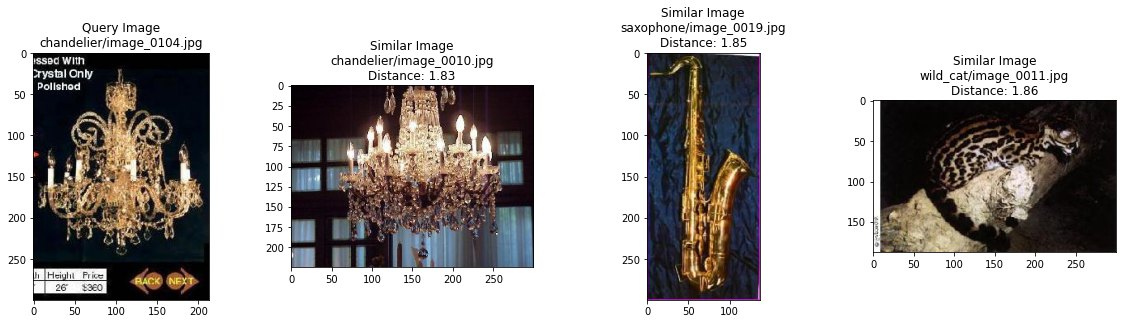

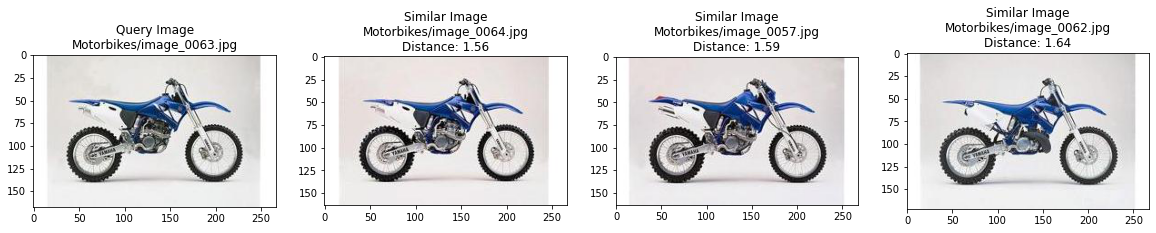

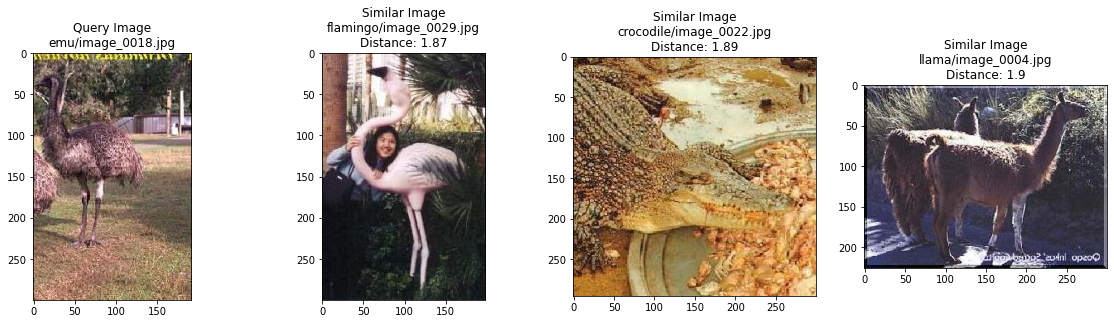

In [ ]:
num_images = len(filenames)

for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

**Annoy Nearest Neighbour Implementation**

In [ ]:
!pip install annoy

     |████████████████████████████████| 655kB 4.3MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp36-cp36m-linux_x86_64.whl size=390361 sha256=2a7b738ed8db3cefc92f1afb18e121a220f6b1f5f1b70cb45c11db28af326da1
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
import joblib
from PIL import Image

In [ ]:
def ann_index(features_path, output_path):
    print("[INFO] Loading Features")
    feature_list = np.load(features_path)
    feature_list = feature_list[:,:,0,0]

    print("[INFO] Running PCA")
    n_components = 128
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(feature_list)
    joblib.dump(pca, os.path.join(output_path, "pca.joblib"))

    print("[INFO] Building Index")
    feature_length = n_components
    index = AnnoyIndex(feature_length, 'angular')
    for i, j in enumerate(components):
        index.add_item(i, j)

    index.build(15)
    index.save(os.path.join(output_path, "index.annoy"))

In [ ]:
def ann(input_path, output_path, filenames_path, index_path, n=6):
    print("Instantiating Model...")
    model = get_base_model()
    preprocess = get_preprocess_pipeline()
    filename_list = np.load(os.path.join(filenames_path))
    
    print("Extracting Feature Vector...")
    im = Image.open(input_path)
    im = preprocess(im)
    im = im.unsqueeze(0)
    with torch.no_grad():
        input_features = model(im).numpy()
        #print(input_features.shape)
        input_features = input_features[:,:,0,0]

    print("Applying PCA...")
    pca = joblib.load(os.path.join(master_path, "pca.joblib"))
    components = pca.transform(input_features)[0]

    print("Loading ANN Index...")
    ann_index = AnnoyIndex(components.shape[0], 'angular')
    ann_index.load(os.path.join(index_path))

    print("Finding Similar Images...\n")
    indices = ann_index.get_nns_by_vector(components, n, search_k=-1, include_distances=False)
    indices = np.array(indices)
    similar_image_paths = filename_list[indices]
   
    plot_images_annoy(similar_image_paths[0:3])
    
    return similar_image_paths

In [ ]:
ann_index(master_path + 'features.npy', master_path)

[INFO] Loading Features
[INFO] Running PCA
[INFO] Building Index


Instantiating Model...
Extracting Feature Vector...
Applying PCA...
Loading ANN Index...
Finding Similar Images...



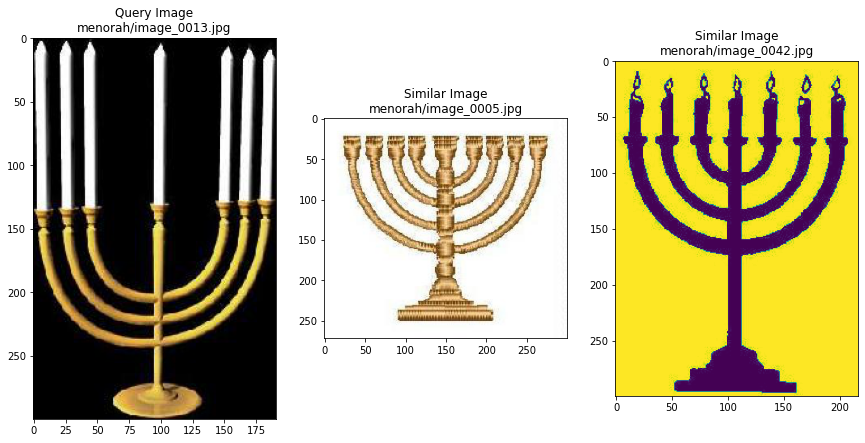

In [ ]:
similar_paths = ann(master_path + 'caltech101/101_ObjectCategories/menorah/image_0013.jpg', master_path, master_path + 'filenames.npy', master_path + 'index.annoy')

Instantiating Model...
Extracting Feature Vector...
Applying PCA...
Loading ANN Index...
Finding Similar Images...



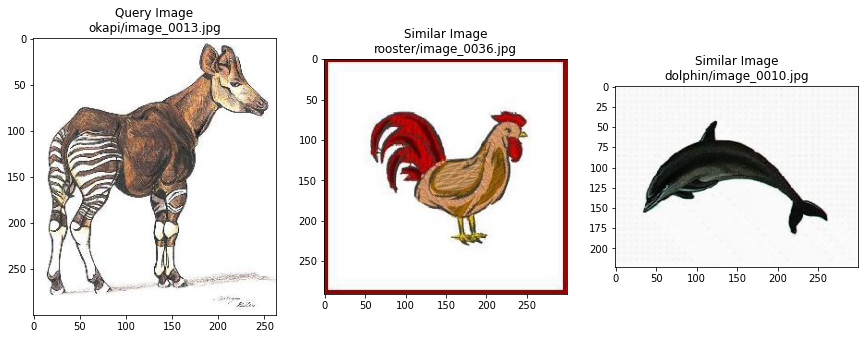

In [ ]:
similar_paths = ann(master_path + 'caltech101/101_ObjectCategories/okapi/image_0013.jpg', master_path, master_path + 'filenames.npy', master_path + 'index.annoy')

**Demonstration**

Instantiating Model...


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Extracting Feature Vector...
Applying PCA...
Loading ANN Index...
Finding Similar Images...

Instantiating Model...
Extracting Feature Vector...
Applying PCA...
Loading ANN Index...
Finding Similar Images...

Instantiating Model...
Extracting Feature Vector...
Applying PCA...
Loading ANN Index...
Finding Similar Images...

Instantiating Model...
Extracting Feature Vector...
Applying PCA...
Loading ANN Index...
Finding Similar Images...



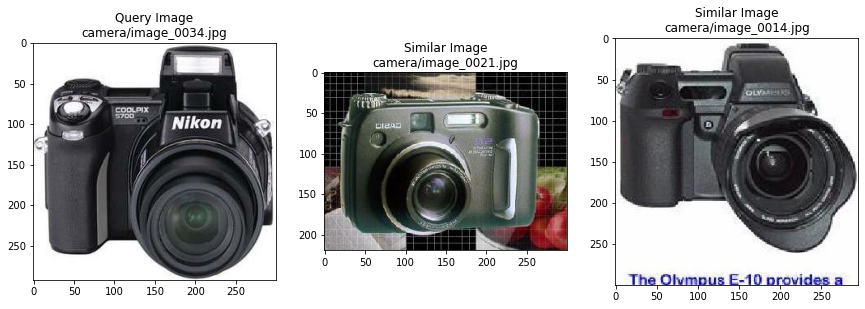

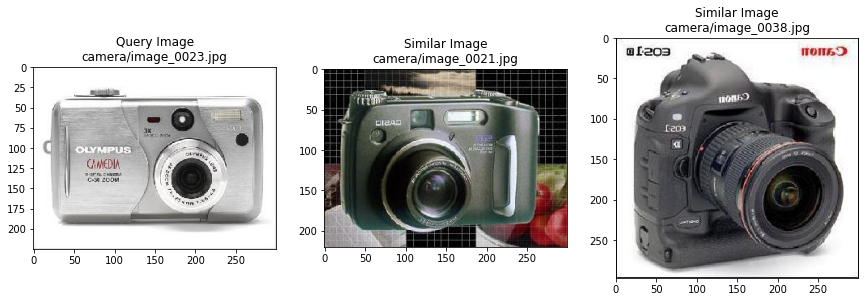

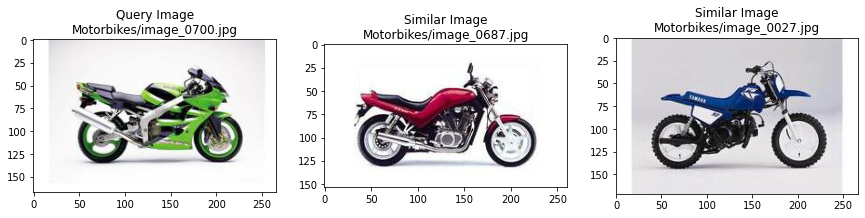

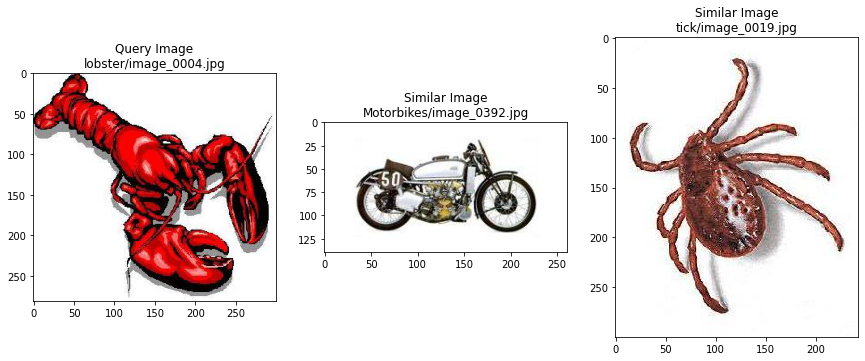

In [ ]:
similar_paths = ann(master_path + 'Examples/test1.jpg', master_path, master_path + 'filenames.npy', master_path + 'index.annoy')
similar_paths = ann(master_path + 'Examples/test2.jpg', master_path, master_path + 'filenames.npy', master_path + 'index.annoy')
similar_paths = ann(master_path + 'Examples/test3.jpg', master_path, master_path + 'filenames.npy', master_path + 'index.annoy')
similar_paths = ann(master_path + 'Examples/test4.jpg', master_path, master_path + 'filenames.npy', master_path + 'index.annoy')

In [ ]:
# similarity_search(master_path + 'caltech101/101_ObjectCategories/menorah/image_0012.jpg')

# Evaluation Metrics

In [ ]:
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_predictions = 0
    incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_predictions += 1
            else:
                incorrect_predictions += 1
    print(
        "Accuracy is ",
        round(
            100.0 * correct_predictions /
            (1.0 * correct_predictions + incorrect_predictions), 2))

In [ ]:
feature_list = np.load(master_path + 'features.npy')
feature_list = feature_list[:,:,0,0]
filenames = np.load(master_path + 'filenames.npy')
calculate_accuracy(feature_list[:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Accuracy is  48.94


In [ ]:
primary_features = np.load(master_path + 'features_primary.npy')
calculate_accuracy(primary_features[:])


num_feature_dimensions = 128
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list[:])

calculate_accuracy(feature_list_compressed[:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Accuracy is  2.79


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Accuracy is  50.37
